In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.misc as misc
import math
import imageio

import ndoperators as ops
import llops as yp
from llops import vec

In [2]:
global_backend = 'arrayfire' # arrayfire or numpy
global_dtype = 'complex32' # complex32 or complex64

ops.setDefaultBackend(global_backend)
ops.setDefaultDatatype(global_dtype)

/Users/zfphil/.conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


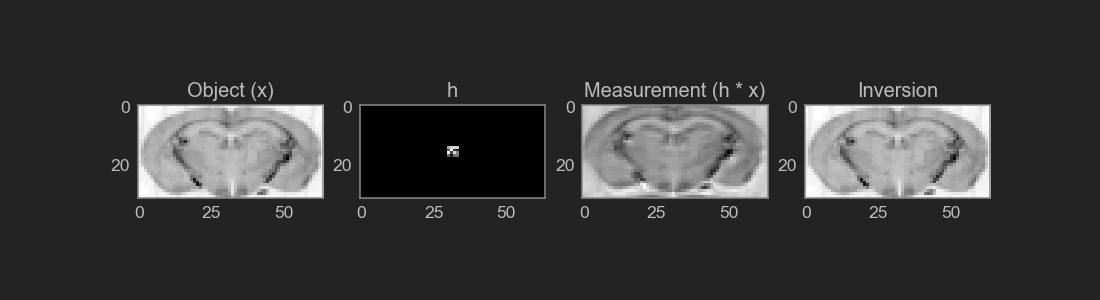

In [3]:
# Image to use when generating object
object_file_name = '../test/brain_to_scan.png'

# Color channel to use when generating object
object_color_channel = 2

# Image size to simulate
image_size = np.array([32, 64])

# Determine machine precision threshold
eps = yp.precision(global_dtype) * np.prod(image_size)

# Load object and crop to size
brain = imageio.imread(object_file_name)
x_0 = np.asfortranarray(sp.misc.imresize(brain, size=image_size)[:, :, object_color_channel].astype(yp.getNativeDatatype(global_dtype, 'numpy')) / 255.)

# Convert object to global default backend
x = yp.changeBackend(x_0)

# Generate convolution kernel h
h_size = np.array([4, 4])
h = yp.zeros(image_size, global_dtype, global_backend)
h[image_size[0] // 2 - h_size[0] // 2:image_size[0] // 2 + h_size[0] // 2,
  image_size[1] // 2 - h_size[1] // 2:image_size[1] // 2 + h_size[1] // 2] = yp.randn((h_size[0], h_size[1]), global_dtype, global_backend)

h /= yp.scalar(yp.sum(yp.abs(h)))

C = ops.Convolution(h, pad_value='mean')
A = C
y = A * x

# Show object and h
plt.figure(figsize=(11,3))
plt.subplot(141)
plt.imshow(yp.abs(yp.changeBackend(x_0, 'numpy')))
plt.title('Object (x)')
plt.subplot(142)
plt.imshow(yp.abs(np.asarray(h)))
plt.title('h')
plt.subplot(143)
plt.imshow((yp.abs(np.asarray(y))))
plt.title('Measurement (h * x)');
plt.subplot(144)
plt.imshow((yp.abs(np.asarray(A.inv * y))))
plt.title('Inversion');

## Using Arrayfire's Convolution

In [97]:
import arrayfire as af

%timeit af.signal.convolve2(x, x)
%timeit af.signal.fft_convolve2(x, x)
%timeit yp.convolve(x, x)

100 µs ± 4.46 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
94 µs ± 1.51 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


NameError: name 'forward_output_dtype' is not defined

In [85]:
import arrayfire as af
yp.shape(af.signal.fft2_r2c(x, yp.shape(x)[0], yp.shape(x)[1]))

## Image Segmentation Operator
This operator takes a list of crop operators as an input and returns a Vstack operator with a specific inversion and adjoint process

In [4]:
crop_size = crop_size = (image_size[0], image_size[0])

roi_list = [yp.Roi(crop_size, start=(0,0), input_shape=image_size),
            yp.Roi(crop_size, start=(0,image_size[1] // 4), input_shape=image_size),
            yp.Roi(crop_size, start=(0,image_size[1] // 2), input_shape=image_size)]

roi_list[0] -= 5

<IPython.core.display.Javascript object>


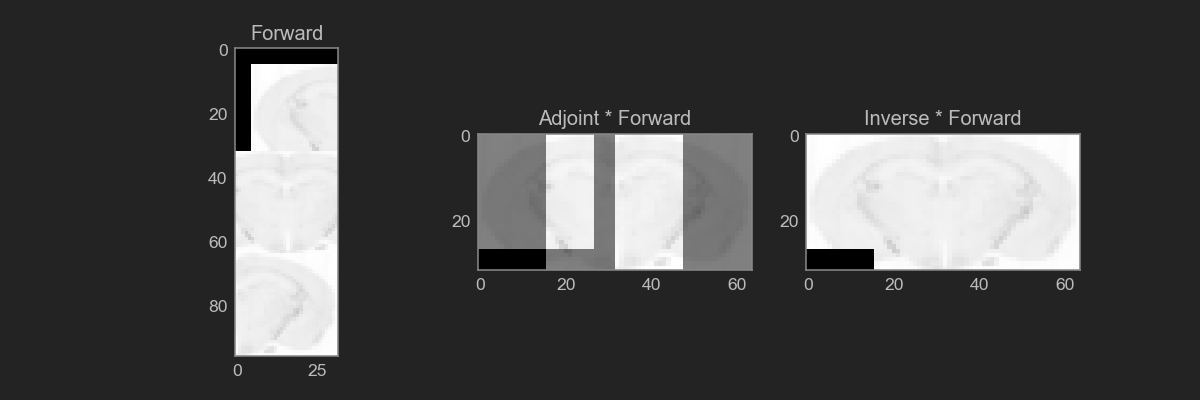

<IPython.core.display.Latex object>

In [7]:
# Create segmentation operatoe
G = ops.Segmentation(roi_list, image_size, alpha_blend_size=0, backend=None)

# Generate measurements
y = G * x

# Apply some mis-calibration to measurement
y_list = ops.VecSplit(y, len(roi_list))

# y_list[1] = yp.circshift(y_list[1], (3, -1))
y_list[1] *= 1.1
y_list[2] *= 0.9

y = ops.VecStack(y_list)

# Show figures
plt.figure()
plt.subplot(131)
plt.imshow(yp.real(y))
plt.title('Forward')
plt.subplot(132)
plt.imshow(yp.real(G.H * y))
plt.title('Adjoint * Forward')
plt.subplot(133)
plt.imshow(yp.real(G.inv * y))
plt.title('Inverse * Forward')

# Perform gradient check
# G.gradient_check()

# Show latex
G.latex()

## Test Segmentation with Illumination Gradient

In [ ]:
self = G

sigma = 5
q = yp.crop(yp.filter.gaussian(yp.pad(yp.ones(self.N, self.dtype, self.backend), [n + 5 * sigma for n in self.N], center=True, pad_value=0), sigma=sigma), self.N, center=True)
q -= yp.min(q)
q /= yp.max(q)

plt.figure()
plt.imshow(yp.real(q))

In [ ]:
ramp_magnitude = 0.1
illum_gradient = yp.ramp(crop_size, 1, max_value=1 + ramp_magnitude, min_value=1 - ramp_magnitude)

# Create segmentation operatoe
G = ops.Segmentation(roi_list, image_size, alpha_blend_size=10)

# Generate measurements
y = G * x

# Apply gradient
y_list = ops.VecSplit(y, 3)
y_list = [y * illum_gradient for y in y_list]

y = ops.VecStack(y_list)

# Show figures
plt.figure()
plt.subplot(131)
plt.imshow(yp.real(y))
plt.title('Forward')
plt.subplot(132)
plt.imshow(yp.real(G.H * y))
plt.title('Adjoint * Forward')
plt.subplot(133)
plt.imshow(yp.real(G.inv * y))
plt.title('Inverse * Forward')

# Perform gradient check
G.gradient_check()

# Show latex
G.latex()

## Unified Shift Operator

In [ ]:
S = ops.Shift(image_size, (20,-10))

shift = S.arguments
shift['shift'] = (1,10)
S.arguments = shift

In [ ]:
S = ops.FFTShift(image_size)

yp.assert_equality(S * x, yp.fftshift(x))
yp.assert_equality(S.H * S * x, x)

plt.figure()
plt.subplot(131)
plt.imshow(yp.abs(x))
plt.subplot(132)
plt.imshow(yp.abs(S * x))
plt.subplot(133)
plt.imshow(yp.abs(S.H * S *  x))

## 1D Registration of 2D Array

In [ ]:
x1 = x_0
x2 = yp.roll(x_0, (10,5))

plt.figure()
plt.subplot(121)
plt.imshow(yp.abs(x1))

plt.subplot(122)
plt.imshow(yp.abs(x2))

In [ ]:
x1 = x_0
x2 = yp.roll(x_0, (1,10))

R = ops.Registration(x1, axes=[1], debug=True)
R.inv * x2

In [ ]:
backends = ['numpy', 'arrayfire']
x = []
x_np = yp.rand(image_size)
for backend in backends:
    x += [ops.FourierTransform(image_size, axes=[1], backend=backend) * yp.changeBackend(x_np, backend)]

# x_np = yp.rand(image_size)
# F_np = ops.FourierTransform(image_size, axes=[1], backend='numpy')
# xf_np = F * x_np

plt.figure()
plt.subplot(121)
plt.imshow(yp.angle((x[0])))
plt.subplot(122)
plt.imshow(yp.angle((x[1])))

## Crop Outside of FOV

In [ ]:
crop_size = (32, 32)
CR = ops.Crop(image_size, crop_size, crop_start=(0,0),pad_value='mean')

CR.arguments = {'crop_offset': (-1,-10)}

x_crop = CR * x

plt.figure()
plt.subplot(131)
plt.imshow(yp.abs(CR.singular_values))
plt.subplot(132)
plt.imshow(yp.abs(CR * x))
plt.subplot(133)
plt.imshow(yp.abs(CR.H * CR * x))

In [ ]:
CR.H * x_crop

## Pad Outside FOV

In [ ]:
crop_size = (32, 32)
CR = ops.Crop(image_size, crop_size, crop_start=(0,0))

CR.arguments = {'crop_offset': (2,33)}

x_crop = CR * x

CR.H * x_crop

In [ ]:
crop_size = (32, 32)
CR = ops.Crop(image_size, crop_size, crop_start=(0,0))

CR.arguments = {'crop_offset': (2,33)}

x_crop = CR * x

plt.figure()
plt.subplot(131)
plt.imshow(yp.abs(CR.singular_values))
plt.subplot(132)
plt.imshow(yp.abs(CR * x))
plt.subplot(133)
plt.imshow(yp.abs(CR.H * CR * x))

## Registration

In [ ]:
# Define true shift
shift = yp.asarray((2,5))

R = ops.Registration(x)

# Generate shifted copies
x1 = yp.dcopy(x)
x2 = R * shift

assert np.all(np.asarray(R.inv * x2) == np.asarray(shift))
# # Show results
# plt.figure(figsize=(12,3))
# plt.subplot(141)
# plt.imshow(yp.abs(x1))
# plt.subplot(142)
# plt.imshow(yp.abs(x2))
# plt.subplot(143)
# plt.imshow(yp.abs(R.inv * x1))
# # plt.subplot(144)
# # plt.imshow(yp.abs(xc2))


## Make Convolution Smarter
Helper functions required:
- isDeltaFunction: Takes array, determines if it's a delta function, and gets it's position

In [ ]:
sz = yp.shape(x)
kernel = yp.zeros(sz)   
# kernel[50,50] = 10
kernel[20,21] = 1
# kernel[20,31] = 0.5

C1 = ops.Convolution(kernel, force_full_convolution=True)
C2 = ops.Convolution(kernel)
print(C1)
print(C2)

plt.figure(figsize=(11,4))
plt.subplot(131)
plt.imshow(yp.abs(x))
plt.colorbar()

plt.subplot(132)
plt.imshow(yp.abs(C1 * x))
plt.colorbar()

plt.subplot(133)
plt.imshow(yp.abs(C2 * x))
plt.colorbar()

print(yp.amax(x))
print(yp.amax(yp.abs(C1 * x)))
print(yp.amax(yp.abs(C2 * x)))

np.sum(np.abs(C1 * x - C2 * x))

## Add Inner-Operators to Convolution
This will be removed if the operator is broken up

In [ ]:
s0 = yp.zeros((2,1))
s1 = yp.ones((2,1))
H = ops.PhaseRamp(image_size)
F = ops.FourierTransform(image_size, center=False, pad=True)
C = ops.Convolution(s0, inside_operator=F.H * H, mode='circular', force_full_convolution=True)

plt.figure(figsize=(11,3))
plt.subplot(121)
plt.imshow(yp.abs(x))
plt.subplot(122)
plt.imshow(yp.abs(C * x))

## Inverting Single Operators

In [ ]:
F = ops.FourierTransform(h.shape)
A = F.H * ops.Diagonalize((F * h), inverse_regularizer=1e-10) * F
y = A * x
yp.abs(A.inv * y)

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(yp.abs(x))
plt.colorbar()
plt.subplot(132)
plt.imshow(yp.abs(y))
plt.colorbar()
plt.subplot(133)
plt.imshow(yp.abs(A.inv * y))
plt.colorbar()

In [ ]:
A = ops.FourierTransform(x.shape)
assert yp.sumb(yp.abs(A.inv * A * x - x)) < 1e-3

A = ops.Identity(x.shape)
assert yp.sumb(yp.abs(A.inv * A * x - x)) < 1e-3

A = ops.Shift(x.shape, (10,10))
assert yp.sumb(yp.abs(A.inv * A * x - x)) < 1e-3

F = ops.FourierTransform(h.shape)
A = F.H * ops.Diagonalize((F * h), inverse_regularizer=1e-10) * F
assert yp.sumb(yp.abs(A.inv * A * x - x)) < 1

## Get Rid of Redundant Operations (Such as $F^H \times F$)

In [ ]:
F = ops.FourierTransform(image_size)
D = ops.Diagonalize(h)
L2 = ops.L2Norm(h.shape)
I = ops.Identity(image_size)
y = F * x

# Simple introspection
A = F.H * F
# assert 'Identity' in str(A)

# Introspection with extra operators on right
A = F.H * F * D
# assert 'Identity' in str(A)

# Introspection with extra operators on left
A = D * F.H * F
# assert 'Identity' in str(A)

# Introspection wiht several opposites
A = F * F.H * F * D * F.H * F
# assert 'Identity' in str(A)

# Introspection wiht several opposites and non-linear variables
A = L2 * (F * F.H * F * D * F.H * F - y)
# assert 'Identity' in str(A)

# Introspection in gradient computation
A = F.H * D * F

## Stacking Operators and Inversion
Target case is 3 crop operators which together cover a region - this operation is invertable by definition but needs to be programmitcally implemented

In [ ]:
crop_size = (32, 32)

operators = [ops.Crop(image_size, crop_size, crop_start=(0,0)),
             ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 4)),
             ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 2))]

# Check inverse 
V = ops.Vstack(operators)
assert all(yp.vec(V.inv * (V * x)) == vec(x))

# Check gradient
V.gradient_check()

# Print latex
V.latex()
V.latex(gradient=True)

## Vertical Stacking and Inverses

In [ ]:
print(V.inv.is_stack)
print(V.is_stack)

In [ ]:
crop_size = (32, 32)

operators = [ops.Crop(image_size, crop_size, crop_start=(0,0)),
             ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 4)),
             ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 2))]

# Check inverse calculation
V = ops.Vstack(operators, normalize=False)

plt.figure(figsize=(14,4))
plt.subplot(141)
plt.imshow(yp.abs(x))
plt.title('$x$')
plt.colorbar()
plt.subplot(142)
plt.imshow(yp.abs(V * x))
plt.title('$Ax$')
plt.colorbar()
plt.subplot(143)
plt.imshow(yp.abs(V.H * V * x))
plt.title('$A^H A x$')
plt.colorbar()
plt.subplot(144)
plt.imshow(yp.abs(V.inv * V * x))
plt.title('$A^{-1} A x$')
plt.colorbar()

## Applying Offsets to Crop Operators

In [ ]:
crop_size = (32, 32)

operators = [ops.Crop(image_size, crop_size, crop_start=(0,0)),
             ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 4)),
             ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 2))]

# Set crop offsets
args = operators[1].arguments
args['crop_offset'] = (0,10)
operators[1].arguments = args

# Check inverse calculation
V = ops.Vstack(operators, normalize=False)

plt.figure(figsize=(14,4))
plt.subplot(141)
plt.imshow(yp.abs(x))
plt.title('$x$')
plt.colorbar()
plt.subplot(142)
plt.imshow(yp.abs(V * x))
plt.title('$Ax$')
plt.colorbar()
plt.subplot(143)
plt.imshow(yp.abs(V.H * V * x))
plt.title('$A^H A x$')
plt.colorbar()
plt.subplot(144)
plt.imshow(yp.abs(V.inv * V * x))
plt.title('$A^{-1} A x$')
plt.colorbar()


## Applying Offsets to Stacked Crop Operators After Formation

In [ ]:
crop_size = (32, 32)

operators = [ops.Crop(image_size, crop_size, crop_start=(0,0)),
             ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 4)),
             ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 2))]

# Check inverse calculation
V = ops.Vstack(operators, normalize=False)

# Set crop offsets
args = V.arguments
args[1]['crop_offset'] = (0,10)
operators[1].arguments = args

# Plot
plt.figure(figsize=(14,4))
plt.subplot(141)
plt.imshow(yp.abs(x))
plt.title('$x$')
plt.colorbar()
plt.subplot(142)
plt.imshow(yp.abs(V * x))
plt.title('$Ax$')
plt.colorbar()
plt.subplot(143)
plt.imshow(yp.abs(V.H * V * x))
plt.title('$A^H A x$')
plt.colorbar()
plt.subplot(144)
plt.imshow(yp.abs(V.inv * V * x))
plt.title('$A^{-1} A x$')
plt.colorbar()

## Speed Optimization For Crop Operators

In [ ]:
crop_size = (32, 32)

operators = [ops.Crop(image_size, crop_size, crop_start=(0,0)),
             ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 4)),
             ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 2))]

# Check inverse calculation
V = ops.Vstack(operators)
y = V * x

yy = yp.zeros(V.stack_operators[0].M)
%timeit V.stack_operators[0].H * yy + V.stack_operators[1].H * yy + V.stack_operators[2].H * yy
%timeit sum([V.stack_operators[i].H * y[V.idx[i]:V.idx[i + 1], :] for i in range(V.nops)])
%timeit V.H * y

## Inverting Diagonalized Operators

In [ ]:
C = ops.Convolution(h, inverse_regularizer=0)
y = C * x

x_star = C.inv * y

plt.figure()
plt.imshow(yp.abs(x_star))

In [ ]:
# Convolution operators
c = ops.Convolution(h, inverse_regularizer=0)
conv_ops = [c] * 3

# Create operators
C = ops.Dstack(conv_ops)

# Create measurements
x3 = ops.VecStack([x] * 3)

# Composite Operator
y = C * ops.VecStack(x3)
C.latex()

# Perform inversion
x_star = C.inv * y

# Show results
plt.figure(figsize=(14,4))
plt.subplot(141)
plt.imshow(yp.abs(x3))
plt.title('$x$')
plt.colorbar()
plt.subplot(142)
plt.imshow(yp.abs(C * x3))
plt.title('$Ax$')
plt.colorbar()
plt.subplot(143)
plt.imshow(yp.abs(C.H * C * x3))
plt.title('$A^H A x$')
plt.colorbar()
plt.subplot(144)
plt.imshow(yp.abs(C.inv * C * x3))
plt.title('$A^{-1} A x$')
plt.colorbar()

## Combining Crops and Convolution Operators for Inversion

In [ ]:
# Crop operations
crop_ops = [ops.Crop(image_size, crop_size, crop_start=(0,0)),
            ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 4)),
            ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 2))]

# Convolution operators
h_crop = crop_ops[1] * h#yp.rand(h.shape)
conv_ops = [ops.Convolution(h_crop, inverse_regularizer=0)] * 3

# Create operators
C = ops.Dstack(conv_ops)
X = ops.Vstack(crop_ops)

# Composite Operator
A = C * X
y = A * x
A.latex()

# Perform inversion
x_star = A.inv * y

# Show results
plt.figure(figsize=(14,4))
plt.subplot(151)
plt.imshow(yp.abs(x))
plt.title('$x$')
plt.colorbar()
plt.subplot(152)
plt.imshow(yp.abs(A * x))
plt.title('$Ax$')
plt.colorbar()
plt.subplot(153)
plt.imshow(yp.abs(A.H * A * x))
plt.title('$A^H A x$')
plt.colorbar()
plt.subplot(154)
plt.imshow(yp.abs(A.inv * A * x))
plt.title('$A^{-1} A x$')
plt.colorbar()
plt.subplot(155)
plt.imshow(yp.abs(A.inv * A * x - x))
plt.title('$A^{-1} A x - x$')
plt.colorbar()

## Operator inside Diagonalize

In [ ]:
# Create phase ramp to diagonalize
H = ops.PhaseRamp(image_size)
s = yp.rand((2,1))

# Create diagonalized phase ramp operator
D = ops.Diagonalize(s, inside_operator=H)

# Check that inside operator is set correctly
assert yp.sum(yp.abs(D * x - ((H * s) * x))) == 0.0

# Check gradient
D.gradient_check()

# Render Latex
D.latex()

## Equality Testing

In [ ]:
D1 = ops.Diagonalize(h)
D_eq = ops.Diagonalize(h)
D_neq = ops.Diagonalize(yp.zeros_like(h))

# Ensure equality is correct
assert D1 == D_eq

# Ensure inequality is correct
assert not D1 == D_neq

F = ops.FourierTransform(image_size, center=True)
F_neq = ops.FourierTransform(image_size, center=False)
F_eq = ops.FourierTransform(image_size, center=True)
assert F == F_eq
assert not F == F_neq

assert F == F_eq
assert not F == F_neq